# Electricity Load Forecasting with Transformer-based Model
This notebook builds and evaluates a multi-horizon Transformer-based model to forecast electricity load up to 24 hours ahead.
It includes data preparation, sequence construction, and systematic model configuration, followed by final evaluation on unseen test data.
Model performance is assessed using standard error metrics, and the results are analyzed to evaluate the model’s predictive accuracy, stability across forecast horizons, and overall robustness.

## Imports

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt

## Loading the Data

In [46]:
# Reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)


In [47]:
# ## Loading the Data

# %%
interim_folder = "../data/processed"
train_val_df = pd.read_csv(os.path.join(interim_folder, "train_val_df.csv"), sep=";", decimal=",")
test_df      = pd.read_csv(os.path.join(interim_folder, "test_df.csv"),      sep=";", decimal=",")

train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"]      = pd.to_datetime(test_df["timestamp"])

print("Train/Val:", train_val_df.shape, " Test:", test_df.shape)


Train/Val: (17517, 14)  Test: (8783, 14)


## Data Preparation and Sequence Generation

The data is sorted chronologically and split into training, validation, and test sets using a time-based validation approach. All features and the target variable are standardized using scalers fitted only on the training data.

Based on the scaled data, sliding window sequences are created with 336 past observations as input and a 24-hour forecast horizon. Decoder input sequences are initialized using a start-token strategy to support multi-step forecasting with the Transformer model.


In [49]:
n_input  = 336
n_output = 24

# Ensure chronological order
train_val_df = train_val_df.sort_values("timestamp").reset_index(drop=True)
test_df      = test_df.sort_values("timestamp").reset_index(drop=True)

# Define a TIME-BASED validation split 
VAL_DAYS = 60
cutoff = train_val_df["timestamp"].max() - pd.Timedelta(days=VAL_DAYS)

train_df = train_val_df[train_val_df["timestamp"] < cutoff].copy()
val_df   = train_val_df[train_val_df["timestamp"] >= cutoff].copy()

print("Train period:", train_df["timestamp"].min(), "→", train_df["timestamp"].max(), "| rows:", len(train_df))
print("Val period  :", val_df["timestamp"].min(),   "→", val_df["timestamp"].max(),   "| rows:", len(val_df))
print("Test period :", test_df["timestamp"].min(),  "→", test_df["timestamp"].max(),  "| rows:", len(test_df))

# Build X/y arrays
target_col = "load_MWh"
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", target_col]]

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values.reshape(-1, 1)

X_val = val_df[feature_cols].values
y_val = val_df[target_col].values.reshape(-1, 1)

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values.reshape(-1, 1)

print(f"Features: {len(feature_cols)}")

# Fit scalers on train
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# Build sequences
def create_sequences(X, y, n_input, n_output):
    """
    X: (T, n_features)
    y: (T, 1)
    Returns:
      X_seq: (N, n_input, n_features)
      y_seq: (N, n_output, 1)
    """
    Xs, ys = [], []
    T = len(X)
    for i in range(T - n_input - n_output + 1):
        Xs.append(X[i:i+n_input, :])
        ys.append(y[i+n_input:i+n_input+n_output, :])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_input, n_output)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   n_input, n_output)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  n_input, n_output)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val seq  :", X_val_seq.shape,   y_val_seq.shape)
print("Test seq :", X_test_seq.shape,  y_test_seq.shape)

# Decoder inputs 
def make_decoder_inputs_start_only(y_full_scaled, n_input, n_output, mode="repeat"):
    """
    Option A decoder inputs:
      - mode="repeat": [start_token, start_token, ..., start_token]
      - mode="zeros" : [start_token, 0, 0, ..., 0]
    y_full_scaled: (T, 1) scaled
    returns: (N, n_output, 1) where N = T - n_input - n_output + 1
    """
    y_full_scaled = np.asarray(y_full_scaled, dtype=np.float32)
    T = len(y_full_scaled)
    N = T - n_input - n_output + 1
    if N <= 0:
        raise ValueError(f"Not enough rows (T={T}) for n_input={n_input}, n_output={n_output}")

    start_tokens = y_full_scaled[n_input - 1 : n_input - 1 + N, 0]  # (N,)

    dec = np.zeros((N, n_output, 1), dtype=np.float32)
    dec[:, 0, 0] = start_tokens

    if mode == "repeat":
        dec[:, :, 0] = start_tokens[:, None]
    elif mode == "zeros":
        pass
    else:
        raise ValueError("mode must be 'repeat' or 'zeros'")
    return dec

DEC_MODE = "repeat"  

decoder_inputs_train = make_decoder_inputs_start_only(y_train_scaled, n_input, n_output, mode=DEC_MODE)
decoder_inputs_val   = make_decoder_inputs_start_only(y_val_scaled,   n_input, n_output, mode=DEC_MODE)

print("Decoder train:", decoder_inputs_train.shape, "| first 5:", decoder_inputs_train[0, :5, 0])
print("Decoder val  :", decoder_inputs_val.shape,   "| first 5:", decoder_inputs_val[0, :5, 0])

# Targets for training (model outputs (N,24))
y_train_targets = y_train_seq.squeeze(-1).astype(np.float32)  # (N_train, 24)
y_val_targets   = y_val_seq.squeeze(-1).astype(np.float32)    # (N_val, 24)

Train period: 2022-01-01 01:00:00 → 2023-11-01 22:00:00 | rows: 16076
Val period  : 2023-11-01 23:00:00 → 2023-12-31 23:00:00 | rows: 1441
Test period : 2024-01-01 00:00:00 → 2024-12-31 23:00:00 | rows: 8783
Features: 12
Train seq: (15717, 336, 12) (15717, 24, 1)
Val seq  : (1082, 336, 12) (1082, 24, 1)
Test seq : (8424, 336, 12) (8424, 24, 1)
Decoder train: (15717, 24, 1) | first 5: [0.02839847 0.02839847 0.02839847 0.02839847 0.02839847]
Decoder val  : (1082, 24, 1) | first 5: [0.24388438 0.24388438 0.24388438 0.24388438 0.24388438]


In [88]:
# Custom Transformer Layers
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


class EncoderBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout_rate)
        self.drop2 = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        attn = self.mha(x, x, training=training)
        attn = self.drop1(attn, training=training)
        x = self.norm1(x + attn)

        ffn = self.ffn(x, training=training)
        ffn = self.drop2(ffn, training=training)
        return self.norm2(x + ffn)


class DecoderBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.cross_mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout_rate)
        self.drop2 = layers.Dropout(dropout_rate)
        self.drop3 = layers.Dropout(dropout_rate)

    def call(self, x, enc_out, training=False):
        L = tf.shape(x)[1]
        mask = tf.linalg.band_part(tf.ones((L, L)), -1, 0)
        mask = tf.reshape(mask, (1, L, L))

        attn1 = self.self_mha(x, x, attention_mask=mask, training=training)
        attn1 = self.drop1(attn1, training=training)
        x = self.norm1(x + attn1)

        attn2 = self.cross_mha(x, enc_out, training=training)
        attn2 = self.drop2(attn2, training=training)
        x = self.norm2(x + attn2)

        ffn = self.ffn(x, training=training)
        ffn = self.drop3(ffn, training=training)
        return self.norm3(x + ffn)

## Building the Transformer-based Model

### 1. Hyperband Hyperparamter Tuning
To speed up hyperparameter tuning, a subset of the training and validation sequences is used. A Transformer Seq2Seq model is built with tunable parameters and optimized using Keras Tuner (Hyperband) based on validation loss.

Early stopping is applied to prevent overfitting, and the best hyperparameter configuration is saved for later final training.

In [51]:
# Subsample for tuning speed
N_TUNE = min(2000, len(X_train_seq))
X_tune   = X_train_seq[:N_TUNE]
dec_tune = decoder_inputs_train[:N_TUNE]
y_tune   = y_train_targets[:N_TUNE]

# Use a (small) subset of your time-based validation for tuning speed
N_VAL_TUNE = min(800, len(X_val_seq))
X_val_tune   = X_val_seq[:N_VAL_TUNE]
dec_val_tune = decoder_inputs_val[:N_VAL_TUNE]
y_val_tune   = y_val_targets[:N_VAL_TUNE]

def build_model(hp: kt.HyperParameters):
    d_model = hp.Choice("d_model", [64, 128, 256])
    num_heads = hp.Choice("num_heads", [2, 4, 8])
    if d_model % num_heads != 0:
        num_heads = 2 # ensure divisibility

    dff = hp.Choice("dff", [128, 256, 512])
    num_layers = hp.Choice("num_layers", [1, 2])
    dropout = hp.Float("dropout", 0.0, 0.4, step=0.1)
    lr = hp.Choice("lr", [1e-4, 3e-4, 1e-3])

    # Inputs
    enc_in = layers.Input(shape=(n_input, X_train_seq.shape[2]), name="encoder_input")
    dec_in = layers.Input(shape=(n_output, 1), name="decoder_input")

    # Encoder
    x = layers.Dense(d_model)(enc_in)
    x = PositionalEncoding(n_input, d_model)(x)
    for _ in range(num_layers):
        x = EncoderBlock(d_model, num_heads, dff, dropout_rate=dropout)(x)
    enc_out = x

    # Decoder
    y = layers.Dense(d_model)(dec_in)
    y = PositionalEncoding(n_output, d_model)(y)
    for _ in range(num_layers):
        y = DecoderBlock(d_model, num_heads, dff, dropout_rate=dropout)(y, enc_out)

    out = layers.Dense(1)(y)
    out = layers.Flatten(name="forecast_output")(out)  # (24,)

    model = Model([enc_in, dec_in], out, name="Transformer_Seq2Seq")
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

tuner_dir = "../models/Transformer/tuner_seq2seq_timeval"
os.makedirs(tuner_dir, exist_ok=True)

tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=30,    
    factor=3,
    directory=tuner_dir,
    project_name="seq2seq_transformer_timeval"
)

stop_early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

tuner.search(
    x=[X_tune, dec_tune],
    y=y_tune,
    validation_data=([X_val_tune, dec_val_tune], y_val_tune),
    epochs=30,
    batch_size=16,
    shuffle=False,
    callbacks=[stop_early],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best HPs:", best_hps.values)

best_hps_path = "../models/Transformer/best_hps_seq2seq_timeval.json"
with open(best_hps_path, "w") as f:
    json.dump(best_hps.values, f, indent=2)
print("Saved best hyperparameters to:", best_hps_path)

Trial 55 Complete [00h 04m 03s]
val_loss: 0.13712391257286072

Best val_loss So Far: 0.09496528655290604
Total elapsed time: 02h 32m 05s

Search: Running Trial #56

Value             |Best Value So Far |Hyperparameter
256               |256               |d_model
8                 |8                 |num_heads
128               |128               |dff
2                 |1                 |num_layers
0.1               |0.1               |dropout
0.001             |0.0001            |lr
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 523ms/step - loss: 5.6203 - mae: 1.5587 - val_loss: 0.8246 - val_mae: 0.7989
Epoch 2/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - loss: 1.0612 - mae: 0.8614 - val_loss: 0.7312 - val_mae: 0.7149
Epoch 3/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - lo

KeyboardInterrupt: 

In [57]:
# reload tuner state from disk and save current best_hps

tuner_dir = "../models/Transformer/tuner_seq2seq_timeval"

tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=30,
    factor=3,
    directory=tuner_dir,
    project_name="seq2seq_transformer_timeval",
    overwrite=False, 
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print("Trials:", len(tuner.oracle.trials))

print("Current best HPs:", best_hps.values)

best_hps_path = "../models/Transformer/best_hps_seq2seq_timeval.json"
with open(best_hps_path, "w") as f:
    json.dump(best_hps.values, f, indent=2)
print("Saved best hyperparameters to:", best_hps_path)


Reloading Tuner from ../models/Transformer/tuner_seq2seq_timeval/seq2seq_transformer_timeval/tuner0.json
Trials: 56
Current best HPs: {'d_model': 256, 'num_heads': 8, 'dff': 128, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0035'}
Saved best hyperparameters to: ../models/Transformer/best_hps_seq2seq_timeval.json


**Key Findings – Hyperparameter Search Results**

- The optimal **Transformer configurations** are consistent across tuning trials, indicating stable model behavior during training.  
- Best performance is achieved with a **model dimension (`d_model`) of 256** and **8 attention heads**, suggesting that a higher-capacity attention mechanism improves multi-horizon forecasting accuracy.  
- A **single encoder–decoder layer** (`num_layers = 1`) proves sufficient, indicating that deeper architectures do not provide additional benefits for this dataset.  
- The feed-forward network size is relatively compact (`dff = 128`), reflecting a balance between model expressiveness and generalization.  
- **Low regularization and conservative optimization settings** yield the best results, with a **dropout rate of 0.1** and a **learning rate of 1e-4**, emphasizing the importance of stable training dynamics.  
- Overall, the tuning results highlight a **robust Transformer setup** that achieves reliable performance for 24-hour-ahead electricity load forecasting.

### 2. Final Model Training
In this step, the Transformer Seq2Seq model is retrained using the previously optimized hyperparameters on the full training dataset with a time-based validation split. The model is trained to jointly predict all 24 forecast horizons in a single forward pass, enabling the learning of interdependencies between consecutive prediction steps.

This unified multi-horizon training approach allows the Transformer to capture temporal dynamics across the entire forecast window while maintaining stable and consistent performance for all 24 prediction horizons.

Epoch 1/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.6537 - mae: 0.6235
Epoch 1: val_loss improved from inf to 0.56976, saving model to ../models/Transformer/best_transformer_seq2seq.keras
983/983 ━━━━━━━━━━━━━━━━━━━━ 202s 200ms/step - loss: 0.6534 - mae: 0.6233 - val_loss: 0.5698 - val_mae: 0.6804 - learning_rate: 1.0000e-04
Epoch 2/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.1934 - mae: 0.3178
Epoch 2: val_loss improved from 0.56976 to 0.48186, saving model to ../models/Transformer/best_transformer_seq2seq.keras
983/983 ━━━━━━━━━━━━━━━━━━━━ 217s 220ms/step - loss: 0.1933 - mae: 0.3178 - val_loss: 0.4819 - val_mae: 0.5939 - learning_rate: 1.0000e-04
Epoch 3/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1636 - mae: 0.2882
Epoch 3: val_loss did not improve from 0.48186
983/983 ━━━━━━━━━━━━━━━━━━━━ 211s 215ms/step - loss: 0.1635 - mae: 0.2881 - val_loss: 0.5363 - val_mae: 0.6207 - learning_rate: 1.0000e-04
Epoch 4/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/

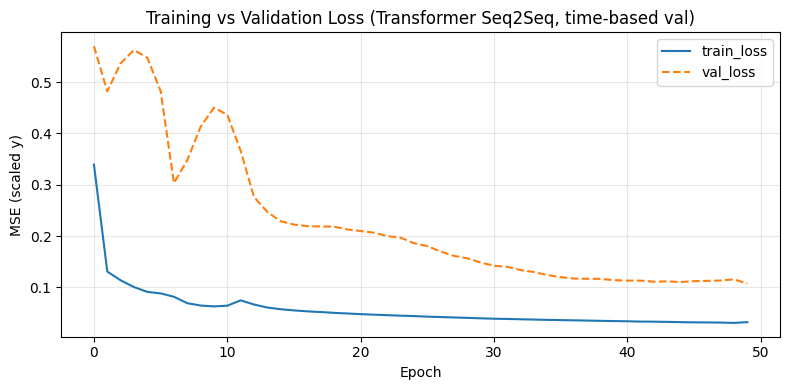

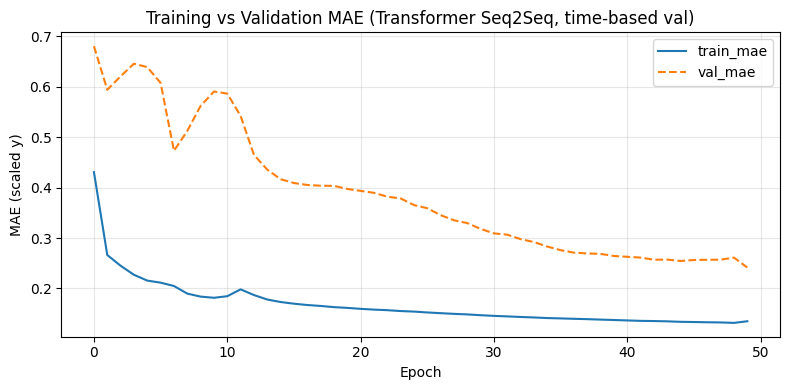

In [53]:
# Final Training of Best Model

best_model = tuner.hypermodel.build(best_hps)

best_lr = float(best_hps.get("lr")) if "lr" in best_hps.values else 1e-4
best_model.compile(optimizer=Adam(learning_rate=best_lr), loss="mse", metrics=["mae"])

model_dir = "../models/Transformer"
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, "best_transformer_seq2seq.keras")

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

history = best_model.fit(
    x=[X_train_seq, decoder_inputs_train],
    y=y_train_targets,
    validation_data=([X_val_seq, decoder_inputs_val], y_val_targets),
    epochs=50,
    batch_size=16,
    shuffle=False,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("Best model saved to:", checkpoint_path)

# Plot

plt.figure(figsize=(8, 4))
plt.plot(history.history.get("mae", []), label="train_mae")
plt.plot(history.history.get("val_mae", []), label="val_mae", linestyle="--")
plt.title("Training vs Validation MAE (Transformer Seq2Seq, time-based val)")
plt.xlabel("Epoch")
plt.ylabel("MAE (scaled y)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Loading the trained transformer model
best_model = tf.keras.models.load_model(
    checkpoint_path,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "EncoderBlock": EncoderBlock,
        "DecoderBlock": DecoderBlock
    }
)

/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'encoder_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'decoder_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` m

### 3. Testing on Future Data
This section evaluates the trained Transformer using a **direct multi-input multi-output (MIMO)** strategy on the unseen test set. For each sliding window, the encoder receives the past `n_input` observations, while the decoder is initialized with a **start-token** (the last observed load value before the forecast horizon), either repeated or followed by zeros depending on `DEC_MODE`.

The model then produces the full **24-step forecast in a single forward pass**. Predictions and ground truth values are inverse-transformed back to MWh, and overall performance is reported using **RMSE** and **MAPE**. In addition, horizon-wise errors are computed to analyze how accuracy changes across the 1–24 hour prediction steps, and a results table with timestamps, actual load, and predicted load is returned for further analysis and plotting.

In [63]:
def evaluate_seq2seq_mimo(
    model,
    X_test_seq,
    y_test_seq,              # (N, 24, 1) scaled
    y_test_scaled_full,      # (T_test, 1) scaled, aligned to test_df (same length!)
    test_df,
    scaler_y,
    n_input,
    n_output,
    step=24,
    dec_mode="repeat",
    eps=1e-6,
    debug_first=True
):
    """
    Direct MIMO evaluation (single forward pass per window):
    - decoder input uses start_token repeated (or start+zeros)
    - model outputs full 24-step forecast in one shot
    """

    # Safety checks 
    assert y_test_scaled_full.ndim == 2 and y_test_scaled_full.shape[1] == 1, \
        f"y_test_scaled_full must be (T,1), got {y_test_scaled_full.shape}"
    assert len(y_test_scaled_full) == len(test_df), \
        f"y_test_scaled_full length must match test_df ({len(test_df)}), got {len(y_test_scaled_full)}"
    assert X_test_seq.shape[0] == len(test_df) - n_input - n_output + 1, \
        "X_test_seq shape does not match expected sliding-window count"

    preds_all, truth_all, ts_all = [], [], []
    errors_by_h = {h: [] for h in range(1, n_output + 1)}

    n_samples = X_test_seq.shape[0]

    for i in range(0, n_samples, step):
        X_in = X_test_seq[i:i+1]                  # (1, n_input, F)
        y_true_scaled = y_test_seq[i].squeeze(-1) # (24,) scaled

        # Start token = last observed y before horizon
        start_token_idx = i + n_input - 1
        start_token = float(y_test_scaled_full[start_token_idx, 0])

        if debug_first and i == 0:
            print("DEBUG window 0 (Direct MIMO)")
            print(" start_token_idx:", start_token_idx)
            print(" start_token (scaled):", start_token)
            print(" first true horizon y (scaled):", float(y_true_scaled[0]))
            print(" ts last encoder:", test_df["timestamp"].iloc[i + n_input - 1])
            print(" ts horizon start:", test_df["timestamp"].iloc[i + n_input])

        # Build decoder input (Option A)
        dec_in = np.zeros((1, n_output, 1), dtype=np.float32)
        dec_in[0, 0, 0] = start_token

        if dec_mode == "repeat":
            dec_in[0, :, 0] = start_token
        elif dec_mode == "zeros":
            pass
        else:
            raise ValueError("dec_mode must be 'repeat' or 'zeros'")

        # One forward pass -> (24,)
        y_pred_scaled = model([X_in, dec_in], training=False).numpy()[0].astype(np.float32)

        # Inverse transform to MWh
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()

        preds_all.extend(y_pred.tolist())
        truth_all.extend(y_true.tolist())

        # Timestamps for the 24 forecast hours
        start_ts = i + n_input
        end_ts   = start_ts + n_output
        ts_all.extend(test_df["timestamp"].iloc[start_ts:end_ts].tolist())

        for h in range(1, n_output + 1):
            errors_by_h[h].append(y_true[h-1] - y_pred[h-1])

    preds_all = np.array(preds_all, dtype=float)
    truth_all = np.array(truth_all, dtype=float)
    ts_all = pd.to_datetime(pd.Series(ts_all).values)

    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(truth_all, preds_all))
    overall_mape = np.mean(np.abs((truth_all - preds_all) / np.clip(np.abs(truth_all), eps, None))) * 100
    print(f"Overall RMSE: {overall_rmse:.2f} MWh | Overall MAPE: {overall_mape:.2f}%")

    # Horizon-wise metrics
    rmse_h, mape_h = [], []
    for h in range(1, n_output + 1):
        e = np.array(errors_by_h[h], dtype=float)
        rmse_h.append(np.sqrt(np.mean(e**2)))

        truth_h = truth_all[h-1::n_output][:len(e)]
        mape_h.append(np.mean(np.abs(e) / np.clip(np.abs(truth_h), eps, None)) * 100)

    results_df = pd.DataFrame({
        "timestamp": ts_all,
        "Actual_Load_MWh": truth_all,
        "Predicted_Load_MWh": preds_all
    })

    return results_df, np.array(rmse_h), np.array(mape_h), errors_by_h


# Run Test evaluation
results_df, rmse_h, mape_h, errors_by_h = evaluate_seq2seq_mimo(
    model=best_model,
    X_test_seq=X_test_seq,
    y_test_seq=y_test_seq,
    y_test_scaled_full=y_test_scaled, 
    test_df=test_df,
    scaler_y=scaler_y,
    n_input=n_input,
    n_output=n_output,
    step=24,
    dec_mode=DEC_MODE,
    debug_first=True
)

display(results_df.head())


DEBUG window 0 (Direct MIMO)
 start_token_idx: 335
 start_token (scaled): 0.05446167601198178
 first true horizon y (scaled): -0.1744539588689804
 ts last encoder: 2024-01-14 23:00:00
 ts horizon start: 2024-01-15 00:00:00
Overall RMSE: 2685.20 MWh | Overall MAPE: 3.79%


,timestamp,Actual_Load_MWh,Predicted_Load_MWh
0,2024-01-15 00:00:00,51829.00,50847.503906
1,2024-01-15 01:00:00,50943.25,49339.089844
2,2024-01-15 02:00:00,49711.00,48561.296875
3,2024-01-15 03:00:00,50230.50,48209.214844
4,2024-01-15 04:00:00,51887.75,48492.601562


### Key Findings Test Evaluation
- The overall test performance indicates **strong predictive accuracy**, with an **RMSE of 2,685 MWh** and a **MAPE of 3.79%**, demonstrating reliable generalization to unseen data.  
- These results confirm the effectiveness of the **Direct MIMO Transformer Seq2Seq approach** for 24-hour electricity load forecasting.

## Visualization of the Model Performance

### 1.Daily Average Electricity Load: Actual vs Predicted
This section compares the predicted and actual electricity load on the test dataset.
Hourly predictions are aggregated to daily averages to visualize overall forecast accuracy and capture long-term trends.
The plot illustrates how closely the Transformer model reproduce real load patterns throughout the test year, providing an intuitive check of model performance and temporal consistency.

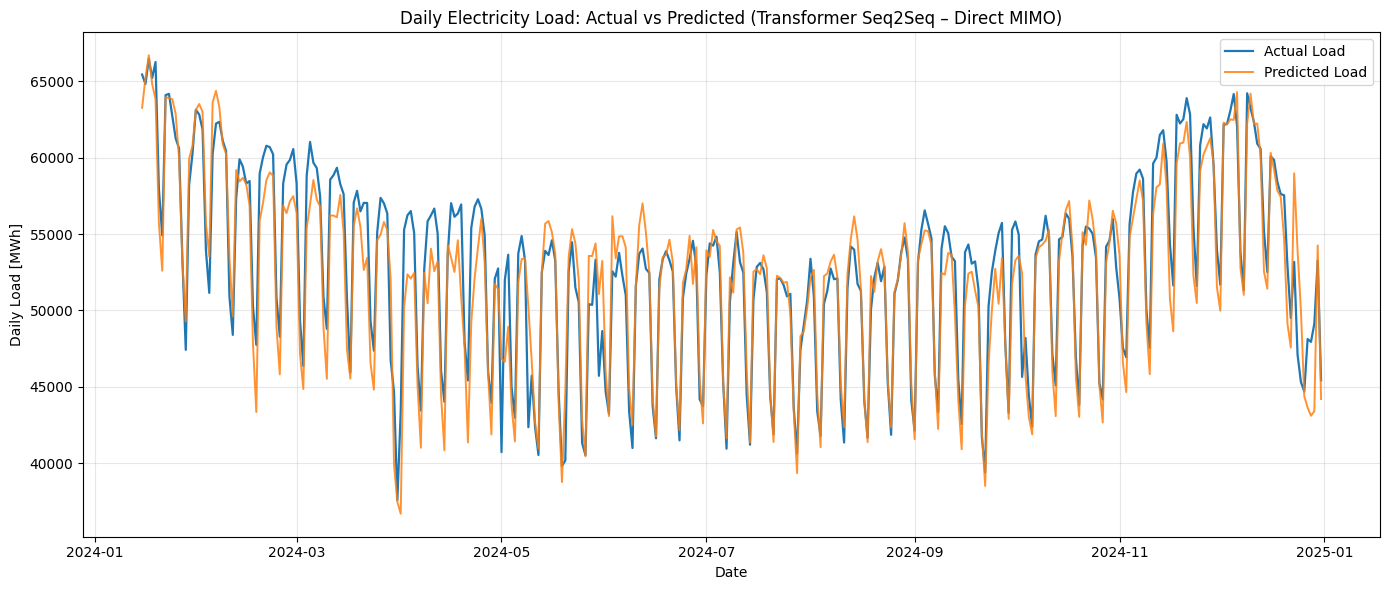

In [76]:
# Ensure timestamp is datetime
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])

# Daily aggregation: choose ONE ---
daily_df = results_df.resample("D", on="timestamp").mean(numeric_only=True).dropna()
plt.figure(figsize=(14, 6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual Load", linewidth=1.6)
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted Load", linewidth=1.4, alpha=0.85)
plt.title("Daily Electricity Load: Actual vs Predicted (Transformer Seq2Seq – Direct MIMO)")
plt.xlabel("Date")
plt.ylabel("Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Key Findings – Daily Electricity Load: Actual vs. Predicted**

- The Transformer Seq2Seq model closely follows the overall electricity load level over the entire test period, indicating strong generalization to unseen data.  
- Seasonal trends and long-term patterns are well captured, including the decrease from winter to summer and the increase toward the end of the year.  
- Regular daily load fluctuations are reproduced accurately, demonstrating the model’s ability to learn short-term cyclical behavior.  
- Larger deviations occur mainly during sharp peaks and troughs, suggesting reduced accuracy for extreme load situations.  
- Overall, the predictions are stable over time with no visible drift or systematic bias, confirming the robustness of the direct multi-horizon forecasting approach.


### 2. Average RMSE & MAPE per Forecast Step
This section visualizes the average RMSE and MAPE for all 24 forecast horizons to assess how prediction accuracy changes with the forecast step.
The plots reveal how errors evolve as the model predicts further into the future, providing insight into short-term vs. long-term forecast reliability.
Together, they highlight the model’s ability to maintain stable performance while quantifying the gradual increase in uncertainty typical of multi-step forecasting.

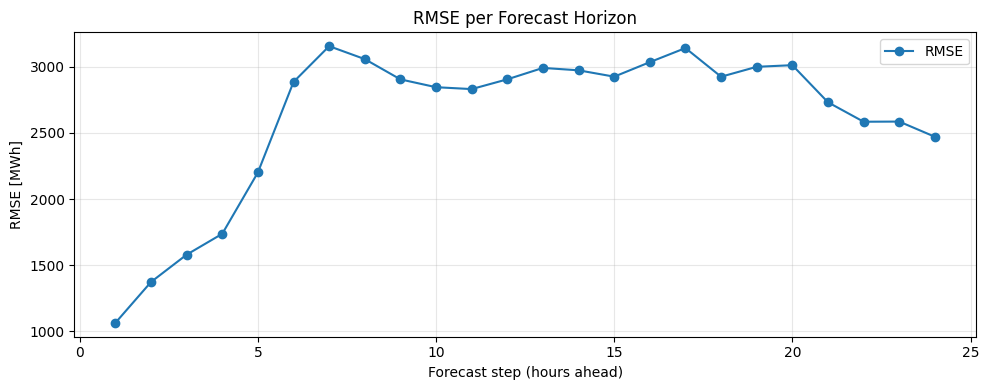

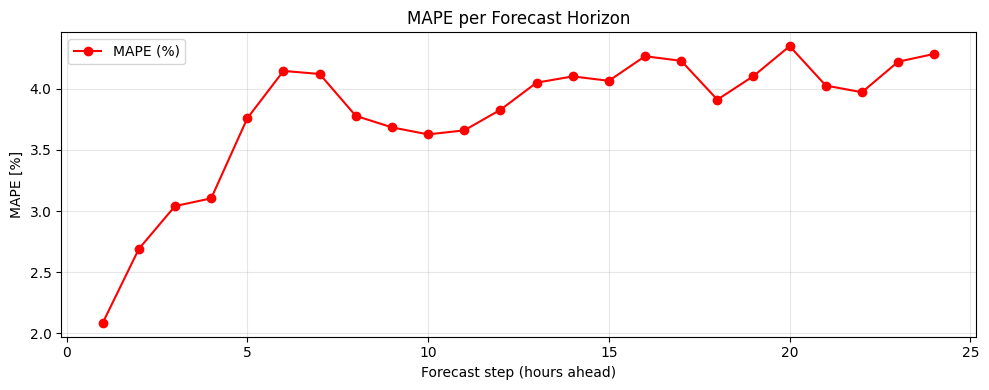

In [86]:
# Plot RMSE per horizon (1–24h)
plt.figure(figsize=(10, 4))
plt.plot(range(1, n_output + 1), rmse_h, marker="o", label="RMSE")
plt.title("RMSE per Forecast Horizon")
plt.xlabel("Forecast step (hours ahead)")
plt.ylabel("RMSE [MWh]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot average MAPE per horizon (1–24h)
plt.figure(figsize=(10, 4))
plt.plot(
    range(1, n_output + 1),
    mape_h,
    marker="o",
    label="MAPE (%)",
    color="red"
)
plt.title("MAPE per Forecast Horizon")
plt.xlabel("Forecast step (hours ahead)")
plt.ylabel("MAPE [%]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**Key Findings – Forecast Accuracy Across Horizons**

- Both **RMSE and MAPE increase with the forecast horizon**, confirming the expected loss of accuracy as predictions extend further into the future.  
- Forecast errors rise sharply within the first few hours and stabilize after approximately **6–8 hours ahead**, indicating that uncertainty grows quickly at short horizons before reaching a relatively steady level.  
- RMSE values remain within a narrow band for mid- and long-term horizons, suggesting **stable error behavior** across most of the 24-hour prediction window.  
- MAPE follows a similar pattern, increasing from around **2% for the 1-hour horizon** to approximately **4–4.5% for longer horizons**, reflecting decreasing relative accuracy over time.  
- Overall, the error profiles demonstrate that the Transformer Seq2Seq model maintains **robust and consistent performance** across all forecast steps, without abrupt degradation at longer horizons.


### 3. Error Distribution Comparison
This section visualizes the distribution of prediction errors for each forecast horizon (1–24 hours ahead) using boxplots.
The plot highlights how the error spread and bias change with the prediction step, revealing where the model tends to overestimate or underestimate the load.
It provides a deeper understanding of forecast stability and uncertainty across different time horizons.

/var/folders/l9/1t32pl1s7bs8hwtdsvql5l0h0000gn/T/ipykernel_20636/3950740410.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(1, n_output + 1))


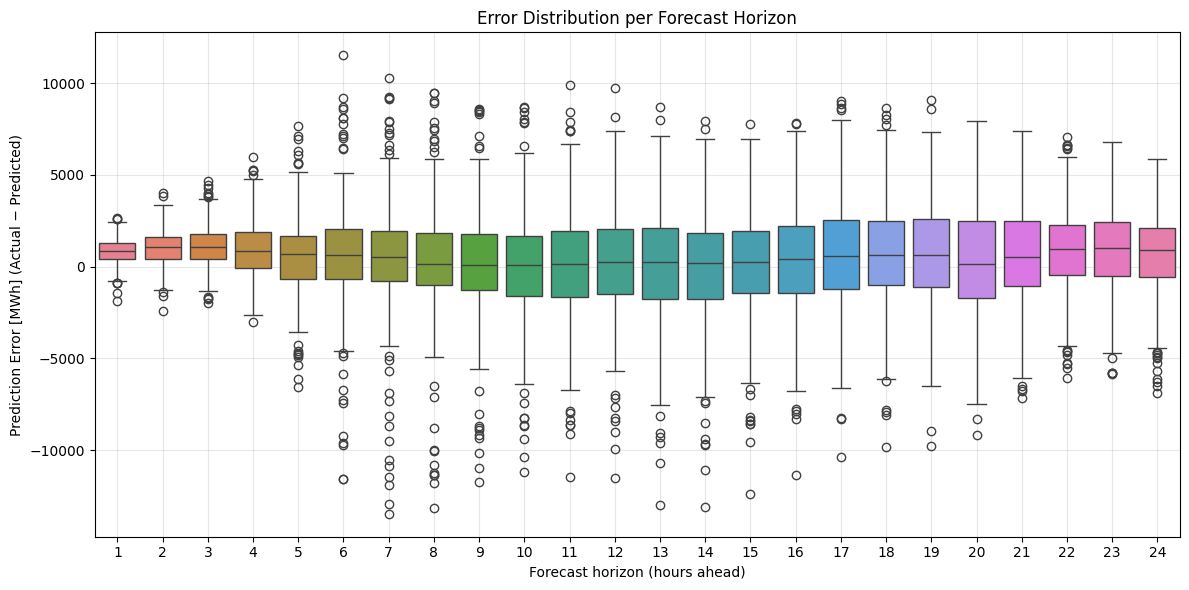

In [87]:
# Create a DataFrame with one column per horizon
errors_df = pd.DataFrame({f"h{h}": errors_by_h[h] for h in range(1, n_output + 1)})

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=errors_df)  
ax.set_xticklabels(range(1, n_output + 1))
plt.title("Error Distribution per Forecast Horizon")
plt.xlabel("Forecast horizon (hours ahead)")
plt.ylabel("Prediction Error [MWh] (Actual − Predicted)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key Findings – Error Distribution per Forecast Horizon**

- The distribution of prediction errors broadens with increasing forecast horizon, indicating rising uncertainty for longer-term predictions.  
- Median errors remain close to zero across all horizons, suggesting **no systematic over- or underestimation** by the Transformer model.  
- The interquartile range increases gradually, reflecting higher variability as the prediction window extends further into the future.  
- Larger outliers appear more frequently at longer horizons, highlighting reduced accuracy during extreme load situations.  
- Overall, the error distributions confirm **stable and unbiased forecasting behavior**, with increasing dispersion that is consistent with expected multi-horizon uncertainty.


## Explainable AI:

In [ ]:
def _to_2d(y):
    """
    Ensures that the target or prediction array has shape (N, n_out).

    - Accepts (N, n_out, 1) and squeezes the last dimension.
    - Raises an error for incompatible shapes to avoid silent bugs.
    """
    y = np.asarray(y)
    if y.ndim == 3 and y.shape[-1] == 1:
        y = y[..., 0]
    if y.ndim != 2:
        raise ValueError(f"Expected 2D (N, n_out), got {y.shape}")
    return y

def rmse_per_horizon(y_true, y_pred):
     """
    Computes the RMSE separately for each forecast horizon.

    Returns:
        Array of shape (n_out,) containing RMSE for each horizon step.
    """
    y_true = _to_2d(y_true)
    y_pred = _to_2d(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))

def rmse_overall(y_true, y_pred):
    """
    Computes a single overall RMSE across all horizons and samples.
    """
    return float(np.sqrt(np.mean(((_to_2d(y_true) - _to_2d(y_pred)) ** 2))))

def permutation_importance_seq2seq(
    model,
    X_enc_seq,
    X_dec_in,
    y_targets,
    feature_names,
    n_repeats=3,
    seed=42,
    horizon_wise=True,
):
    """
    Computes permutation-based feature importance for a Seq2Seq Transformer.

    Each encoder feature is permuted across samples (time structure within
    each sample is preserved). The decoder input is kept fixed.

    Importance is measured as the increase in RMSE (ΔRMSE) relative to
    the unpermuted baseline.
    """
    rng = np.random.default_rng(seed)

    # baseline
    base_pred = _to_2d(model.predict([X_enc_seq, X_dec_in], verbose=0))
    base_rmse_h = rmse_per_horizon(y_targets, base_pred)
    base_rmse = rmse_overall(y_targets, base_pred)

    N, n_input, F = X_enc_seq.shape
    n_out = y_targets.shape[1]

    if len(feature_names) != F:
        raise ValueError(f"feature_names ({len(feature_names)}) must match F ({F})")

    importances = np.zeros((F, n_out), dtype=float) if horizon_wise else np.zeros(F, dtype=float)

    for f in range(F):
        deltas = []
        for _ in range(n_repeats):
            Xp = X_enc_seq.copy()
            perm_idx = rng.permutation(N)
            Xp[:, :, f] = X_enc_seq[perm_idx, :, f]

            pred = _to_2d(model.predict([Xp, X_dec_in], verbose=0))

            if horizon_wise:
                deltas.append(rmse_per_horizon(y_targets, pred) - base_rmse_h)
            else:
                deltas.append(rmse_overall(y_targets, pred) - base_rmse)

        importances[f] = np.mean(deltas, axis=0)

    return {
        "feature_names": feature_names,
        "base_rmse": base_rmse,
        "base_rmse_h": base_rmse_h,
        "importances": importances,
        "horizon_wise": horizon_wise
    }

def plot_perm_importance_heatmap(pi, title="Permutation Importance (ΔRMSE) Feature × Horizon"):
    """
    Visualizes horizon-wise permutation importance as a heatmap.
    """
    imp = pi["importances"]
    names = pi["feature_names"]
    if imp.ndim != 2:
        raise ValueError("Heatmap expects horizon_wise=True (2D importances).")

    plt.figure(figsize=(12, 6))
    plt.imshow(imp, aspect="auto")
    plt.colorbar(label="ΔRMSE")
    plt.yticks(range(len(names)), names)
    plt.xlabel("Forecast horizon (0 = t+1)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def top_features_overall_from_horizonwise(pi, top_k=10):
    """
    Aggregates horizon-wise importance by averaging ΔRMSE across horizons
    and returns the top-k most important features.
    """
    imp = pi["importances"]
    names = pi["feature_names"]
    agg = imp.mean(axis=1)
    order = np.argsort(agg)[::-1][:top_k]
    return [(names[i], float(agg[i])) for i in order]


In [ ]:
feature_names = ["load_MWh","lag_1","lag_2","lag_3","lag_6","lag_24","lag_168","lag_336","lag_672","lag_8760","hour","weekday","is_weekend"]
feature_names = feature_cols 

X_enc = X_test_seq
X_dec = make_decoder_inputs_start_only(y_test_scaled, n_input, n_output, mode=DEC_MODE)
y_tgt = y_test_seq.squeeze(-1).astype(np.float32)  # (N, 24)


In [82]:
base_pred = _to_2d(best_model.predict([X_enc, X_dec], verbose=0))
base_rmse = rmse_overall(y_tgt, base_pred)
base_rmse_h = rmse_per_horizon(y_tgt, base_pred)

print("Baseline RMSE overall (scaled):", base_rmse)
print("Baseline RMSE per horizon (scaled):", base_rmse_h)


Baseline RMSE overall (scaled): 0.28044116497039795
Baseline RMSE per horizon (scaled): [0.13336909 0.17705159 0.20556897 0.22711241 0.24693535 0.2555936
 0.26529476 0.27062953 0.27726418 0.2808549  0.2882921  0.29128912
 0.29452783 0.29719427 0.30260646 0.30905038 0.30940256 0.30882075
 0.3103915  0.31338835 0.31343892 0.31790867 0.32054704 0.31787914]


In [83]:
# Overall permutation importance
pi_h = permutation_importance_seq2seq(
    model=best_model,
    X_enc_seq=X_enc,
    X_dec_in=X_dec,
    y_targets=y_tgt,
    feature_names=feature_names,
    n_repeats=3,
    seed=42,
    horizon_wise=True
)

print("Top features overall (mean ΔRMSE across horizons):")
for name, val in top_features_overall_from_horizonwise(pi_h, top_k=10):
    print(f"  {name:>20s}: {val:.6f}")


Top features overall (mean ΔRMSE across horizons):
              lag_8760: 0.161600
                 lag_6: 0.107208
                  hour: 0.103571
                 lag_3: 0.097177
                 lag_2: 0.080419
               weekday: 0.072498
            is_weekend: 0.070997
                 lag_1: 0.070891
                lag_24: 0.060662
               lag_672: 0.041662


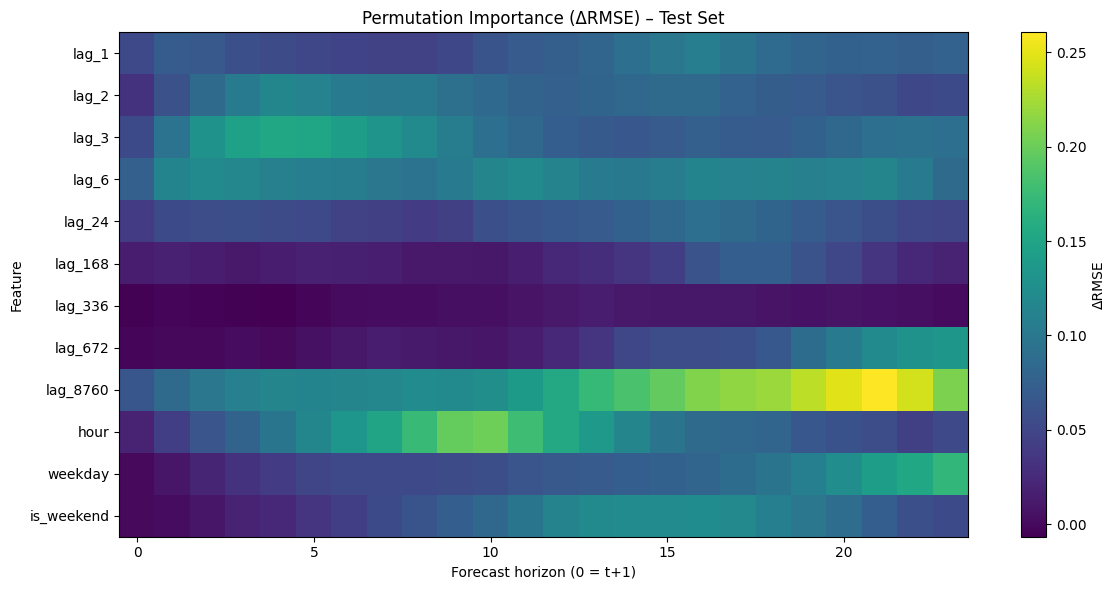

In [84]:
# Plot heatmap of permutation importance
plot_perm_importance_heatmap(pi_h, title="Permutation Importance (ΔRMSE) – Test Set")

### Key Findings – RMSE-based Permutation Importance (Horizon-wise)

- **Short-term horizons (t+1 to t+6)** are dominated by recent lagged load values (`lag_1`, `lag_2`, `lag_3`, `lag_6`), indicating strong short-term persistence and autocorrelation in electricity demand.  
- **Medium-term horizons (approximately t+6 to t+14)** show a decreasing influence of short lags, while **time-of-day effects (`hour`)** become increasingly important, reflecting pronounced daily consumption cycles.  
- **Longer horizons (t+12 to t+24)** are primarily driven by **annual seasonality (`lag_8760`)**, which exhibits the highest RMSE increase when permuted, highlighting its critical role for longer-term forecasts.  
- Calendar-related features such as **`weekday`** and **`is_weekend`** gain relevance with increasing horizon length, indicating a shift from short-term persistence to structural and behavioral patterns.  
- Overall, the RMSE-based permutation importance reveals a **systematic transition of dominant predictors** from short-term load history to cyclical and seasonal drivers as the forecast horizon increases, confirming that the Transformer model learns meaningful temporal dependencies.


## Overall Conclusion
- A Transformer-based Seq2Seq model with a **direct multi-horizon (MIMO)** setup was successfully developed for 24-hour electricity load forecasting, demonstrating stable and robust performance on unseen test data.  
- The model achieves an **overall test RMSE of 2,685 MWh** and a **MAPE of 3.79%**, confirming strong generalization capability despite the increasing uncertainty associated with multi-step forecasts.  
- Horizon-wise evaluation shows a **gradual and expected increase in forecast errors**, with no abrupt degradation at longer horizons, indicating consistent performance across all 24 prediction steps.  
- Visual inspection of daily aggregated forecasts reveals that the model accurately captures **seasonal trends, daily cycles, and long-term dynamics**, while deviations mainly occur during extreme load peaks and troughs.  
- Error distribution analysis confirms **unbiased predictions**, with median errors close to zero and increasing dispersion for longer horizons, consistent with theoretical expectations for multi-horizon forecasting.  
- Permutation-based explainable AI analysis identifies a **clear shift in dominant predictors** across the forecast horizon: short-term forecasts are driven by recent load history, medium-term forecasts by daily cycles, and long-term forecasts by annual seasonality.  
- Overall, the results demonstrate that the Transformer model effectively learns **meaningful temporal structures** in electricity demand data and provides a transparent and interpretable forecasting framework suitable for real-world short-term load forecasting.